In [85]:
import os


In [86]:
from dotenv import load_dotenv
load_dotenv()

True

In [87]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [88]:

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro-latest")

In [89]:
from typing import Annotated
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent


In [90]:
members1=["manage_overloaded_restaurant","damaged_packaging_dispute","communicate"]

In [91]:
options=members1+['FINISH']

In [92]:
class State(MessagesState):
    next:str

In [93]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal["manage_overloaded_restaurant","damaged_packaging_dispute","communicate", 'FINISH']

In [94]:
system_prompt=f"""
You are a supervisor agent of grab-food section, tasked with managing a orchestration between the following agents: {members1
}. 

"""

In [95]:
def grab_food(state:State)->Command[Literal["manage_overloaded_restaurant","manage_packaging_dispute","communicate", '__end__']]:
    messages = [{"role": "system", "content": system_prompt},] + state["messages"] # in this message the content will be the if issue is orderring if the preparation time is excess then it will call the overloaded restaurant tool
    if state.next == "manage_overloaded_restaurant":
        messages.append({"role": "user", "content": "The restaurant is overloaded, please manage the situation."})
    elif state.next == "manage_packaging_dispute":
        messages.append({"role": "user", "content": "There is a dispute regarding damaged packaging."})
    elif state.next == "communicate":
        messages.append({"role": "user", "content": "Please communicate with the customer."})
    else:
        messages.append({"role": "user", "content": "No further action is needed."})
    
    response=llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto=="FINISH":
        goto =END

    return Command(goto=goto,update={"next":goto})

In [96]:
from langchain_core.tools import tool

@tool
def notify_customer(delay_minutes: int) -> str:
    """
    Notify the customer about long wait times and offer a voucher for the inconvenience.
    
    Args:
        delay_minutes: The expected delay in minutes
        
    Returns:
        A message confirming the customer has been notified
    """
    return f"Customer notified about {delay_minutes} minute delay. A voucher has been offered for the inconvenience."

@tool
def reroute_driver(delay_minutes: int) -> str:
    """
    Re-route the driver to a short, nearby delivery while food is being prepared.
    
    Args:
        delay_minutes: The expected delay in minutes
        
    Returns:
        A message confirming the driver has been rerouted
    """
    return f"Driver has been rerouted to a nearby delivery that can be completed within {delay_minutes} minutes while food is being prepared."

@tool
def suggest_alternatives(delay_minutes: int) -> str:
    """
    Find a similar restaurant nearby with a shorter wait time and propose it to the customer.
    
    Args:
        delay_minutes: The expected delay in minutes
        
    Returns:
        A message with alternative restaurant suggestions
    """
    return f"Customer has been provided with 3 similar restaurant alternatives with wait times under {delay_minutes//2} minutes."

def manage_overloaded_restaurant(state: State) -> Command[Literal["grab_food"]]:
    """
    Handle situations where a restaurant is overloaded with orders, causing long wait times.
    Uses tools to notify customer, reroute driver, and suggest alternatives if needed.
    """
    # Create a React agent that uses our tools
    tools = [notify_customer, reroute_driver, suggest_alternatives]
    
    # Create a system message to guide the agent
    system_message = """
    You are a Grab Food order management agent handling an overloaded restaurant situation.
    The kitchen prep time is 40 minutes, which is longer than usual.
    
    Follow these steps:
    1. Notify the customer about the long wait time and offer a voucher
    2. Optimize driver time by re-routing them to another nearby delivery
    3. If the delay is critical, suggest alternative restaurants to the customer
    
    Use the available tools to complete these tasks efficiently.
    """
    
    # Create an agent that can use the tools to handle the overloaded restaurant
    agent = create_react_agent(llm, tools, system_message)
    
    # Add the user query to the messages
    messages = state["messages"] + [
        HumanMessage(content="The restaurant is overloaded with a 40-minute prep time. Handle this situation.")
    ]
    
    # Run the agent
    agent_response = agent.invoke(messages)
    
    
        # If no action was taken, loop back to grab_food
    goto = "grab_food"
    
    
        
    return Command(goto=goto, update={"next": goto})

In [97]:
@tool
def initiate_mediation_flow():
    """ tool which will stop the order and also it will open a portal on both parties the driver and the customer"""
    pass

In [98]:
@tool
def collect_evidence():
    """ tool to collect evidence from both parties of damaged packaging"""
    pass

In [99]:
from langgraph.prebuilt import create_react_agent

@tool
def issue_instant_refund():
    """Tool to issue an instant refund to the customer"""
    return {"action": "refund issued"}

@tool
def exonerate_driver():
    """Tool to exonerate the driver from blame"""
    return {"action": "driver exonerated"}

@tool
def log_merchant_packaging():
    """Tool to log merchant packaging details"""
    return {"action": "merchant packaging logged"}


tools1 = [issue_instant_refund, exonerate_driver, log_merchant_packaging]

def analyze_evidence(state: dict):
    """Sub-agent that analyzes evidence and chooses an action"""
    agent = create_react_agent(llm, tools1)
    
    # Feed the evidence into the sub-agent
    result = agent.invoke({"input": state.get("evidence", "No evidence provided")})
    
    # Store decision in state
    state["analysis"] = result
    return state


In [116]:
def manage_packaging_dispute(state: State) -> Command[Literal['grab_food']]:
    """This is the subagent to manage packaging dispute"""

    # Create the workflow graph for packaging dispute resolution
    workflow = StateGraph(State)
    
    # Add nodes to the workflow
    workflow.add_node("initiate_mediation_flow", initiate_mediation_flow)
    workflow.add_node("collect_evidence", collect_evidence)
    workflow.add_node("analyze_evidence", analyze_evidence)
    
    # Add edges between nodes
    workflow.add_edge("initiate_mediation_flow", "collect_evidence")
    workflow.add_edge("collect_evidence", "analyze_evidence")
    workflow.add_edge("analyze_evidence", "initiate_mediation_flow")
    
    # Set the entry point
    workflow.set_entry_point("initiate_mediation_flow")
    
    # Compile the workflow
    compiled_workflow = workflow.compile()
    
    # Display the workflow diagram
    try:
        from IPython.display import display, Image
        display(Image(compiled_workflow.get_graph().draw_mermaid_png()))
    except Exception as e:
        print(f"Error displaying workflow: {e}")
    
    # Return to grab_food after handling the dispute
    goto = "grab_food"
    return Command(goto=goto, update={"next": goto})

In [117]:
def communicate(state:State)->Command[Literal['grab_food']]:
    """this is a subagent for communicatiiing the fiinal message to the customer"""

    goto="grab_food"
    return Command(goto=goto, update={"next": goto})

In [118]:
# Create the workflow graph
graph = StateGraph(State)

# Add all nodes to the graph

graph.add_node("grab_food", grab_food)
graph.add_node("manage_overloaded_restaurant", manage_overloaded_restaurant)
graph.add_node("manage_packaging_dispute", manage_packaging_dispute)
graph.add_node("communicate", communicate)

graph.set_entry_point("grab_food")

app=graph.compile()

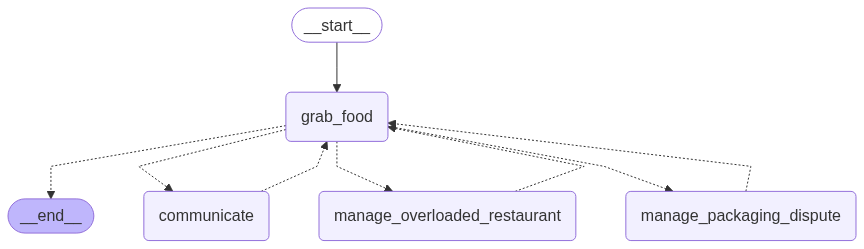

In [119]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))